In [26]:
import numpy as np
from SplineEncodingModel import LinearRegressionSpline as lrsp
import matplotlib.pyplot as plt

%matplotlib inline


0.9048374180359595
0.8187307530779818
0.7408182206817179
0.6703200460356393
0.6065306597126334
0.5488116360940265
0.49658530379140947
0.44932896411722156
0.4065696597405991
0.36787944117144233
0.33287108369807955
0.301194211912202
0.27253179303401254
0.24659696394160643
0.2231301601484298
0.20189651799465538
0.1826835240527346
0.1652988882215865
0.14956861922263504


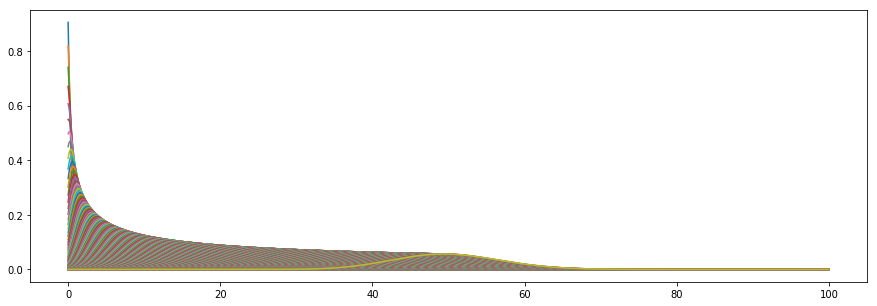

In [33]:
f,ax = plt.subplots(figsize= [15,5])
y = np.logspace(-10,2,num=100000)
dy = np.append(y[,y[1:]-y[0:-1])
const = []
for lam in np.arange(0.1,50,.1).tolist():
    ax.plot(y,lrsp._gamma_pdf_unnorm(y,lam))
#     print(lrsp._gamma_pdf_unnorm(y,lam).sum())
    if lam<2:
        print(lrsp._gamma_pdf_unnorm(0,lam))
    const.append((lrsp._gamma_pdf_unnorm(y,lam)*dy).sum())
    


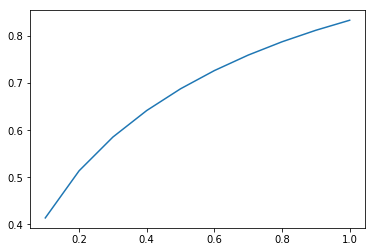

In [37]:
f,ax = plt.subplots()
ax.plot(np.arange(0.1,50,.1)[:10],np.array(const[:10]))

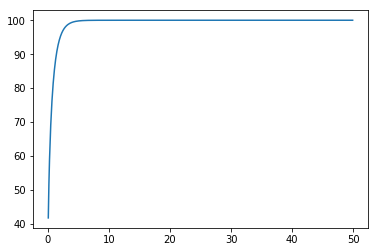

In [20]:
f,ax = plt.subplots()
ax.plot(np.arange(0.1,50,.1),const)

In [9]:
print

[0.7583748157409947, 0.7441726794293311, 0.7152505358525704, 0.6847629881058201, 0.6562849597377405, 0.6308958567058268, 0.6087869768328721, 0.5897978970265386, 0.5736324647284295, 0.5599546551625061, 0.5484327126278937, 0.5387590067173142, 0.5306578857116623, 0.523887471517363, 0.5182384322588477, 0.5135313374788697, 0.5096134584590267, 0.5063554757858388, 0.5036483345499785, 0.5014003629170342, 0.49953469956174795, 0.49798703638233666, 0.49670366195261256, 0.49563978080147, 0.4947580794076168, 0.4940275091251552, 0.49342225752860636, 0.4929208819315682, 0.4925055815224264, 0.492161587339836, 0.49187665199133573, 0.4916406235009026, 0.49144508991024793, 0.4912830832415913, 0.4911488331627097, 0.4910375621948409, 0.49094531559201987, 0.4908688201199176, 0.49080536689630677, 0.49075271424564365, 0.49070900718687765, 0.4906727107342965, 0.49064255466175055, 0.49061748777466474, 0.49059664006374354, 0.49057929138934275, 0.490564845574838, 0.4905528089783453, 0.4905427727710715, 0.49053439